# Work FLow
- `Packages and Libraries`
-  `Load raw audio data` from files in .WAV format that can be processed
-  `EDA`
-  `Spectral Representations` Convert the audio signal into a frequency domain representation, such as a spectrogram or mel spectrogram.
-  `Conversion to TensorFlow` Convert the preprocessed data into a format suitable for the deep learning framework.
-  `Data Splitting` Split the dataset into training, validation, and testing sets.
-  `Model Building` Build your machine learning model using the preprocessed data.
-  `Converting to TFLite model`

# Packages and Libraries

In [1]:
import os
import pathlib
import wave
import shutil

import librosa
import librosa.display

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import soundfile as sf

import IPython.display as display
from IPython.display import Audio, display


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

SAMPLE_RATE = 16000

2024-03-10 07:45:18.743970: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-10 07:45:18.829544: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-10 07:45:18.829604: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-10 07:45:18.831447: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-10 07:45:18.847208: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-10 07:45:18.848625: I tensorflow/core/platform/cpu_feature_guard.cc:1

# Loading Raw Audio Data File Paths

The dataset's audio clips are of 6 classes and stored in six folders corresponding to each speech command: 
- `ddyo`
- `kkono`
- `mu maaso`
- `emabega`
- `yimirira`
- `gaali`

In [2]:
TRAIN_DATASET_PATH = 'Dataset/Train'
TEST_DATASET_PATH = 'Dataset/Test'

PROCESS_TRAIN_DATASET_PATH = 'Dataset/Process_train'
PROCESS_TEST_DATASET_PATH = 'Dataset/Process_test'


train_data_dir = pathlib.Path(TRAIN_DATASET_PATH)
test_data_dir = pathlib.Path(TEST_DATASET_PATH)

process_train_data_dir = pathlib.Path(PROCESS_TRAIN_DATASET_PATH)
process_test_data_dir = pathlib.Path(PROCESS_TEST_DATASET_PATH)

# Functions

## 1. Duration(2s), and channel (mono) check function

In [3]:
def move_audio_files(data_dir, process_folder):
    if not os.path.exists(process_folder):
        os.makedirs(process_folder)

    for subfolder in os.listdir(data_dir):
        subfolder_path = os.path.join(data_dir, subfolder)
        if os.path.isdir(subfolder_path):
            for audio_file in os.listdir(subfolder_path):
                audio_path = os.path.join(subfolder_path, audio_file)
                try:
                    # Get audio length and number of channels
                    with wave.open(audio_path, 'r') as wav_file:
                        audio_length = wav_file.getnframes() / wav_file.getframerate()
                        num_channels = wav_file.getnchannels()

                    if audio_length > 2.0 or num_channels != 1:
                        # Move the audio file to the process folder
                        shutil.move(audio_path, os.path.join(process_folder, audio_file))
                except Exception as e:
                    print(f"Error processing {audio_path}: {e}")


move_audio_files(train_data_dir, process_train_data_dir)
move_audio_files(test_data_dir, process_test_data_dir)

## 2. Count audio files function

In [4]:
def count_audio_files_in_subfolders(data_dir):
    counts = {}
    for subfolder in os.listdir(data_dir):
        subfolder_path = os.path.join(data_dir, subfolder)
        if os.path.isdir(subfolder_path):
            audio_files_count = len([f for f in os.listdir(subfolder_path) if f.endswith('.wav')])
            counts[subfolder] = audio_files_count
    return counts

## 3. Function to determine the size of the model

In [5]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

# Exploratory Data Analysis (EDA) 

## Labels

In [6]:
commands = np.array(tf.io.gfile.listdir(str(train_data_dir)))
print(f'Train commands labels: {commands}')

commands = np.array(tf.io.gfile.listdir(str(test_data_dir)))
print(f'Test commands labels:  {commands}')

Train commands labels: ['mu masso' 'ddyo' 'kkono' 'gaali' 'yimirira' 'emabega']
Test commands labels:  ['mu masso' 'ddyo' 'kkono' 'gaali' 'yimirira' 'emabega']


## Number of audio files

### 1. Train dataset

In [7]:
counts = count_audio_files_in_subfolders(train_data_dir)
print(f'Train \n{counts}')
print()

Train 
{'mu masso': 1566, 'ddyo': 1563, 'kkono': 1587, 'gaali': 1440, 'yimirira': 1501, 'emabega': 1546}



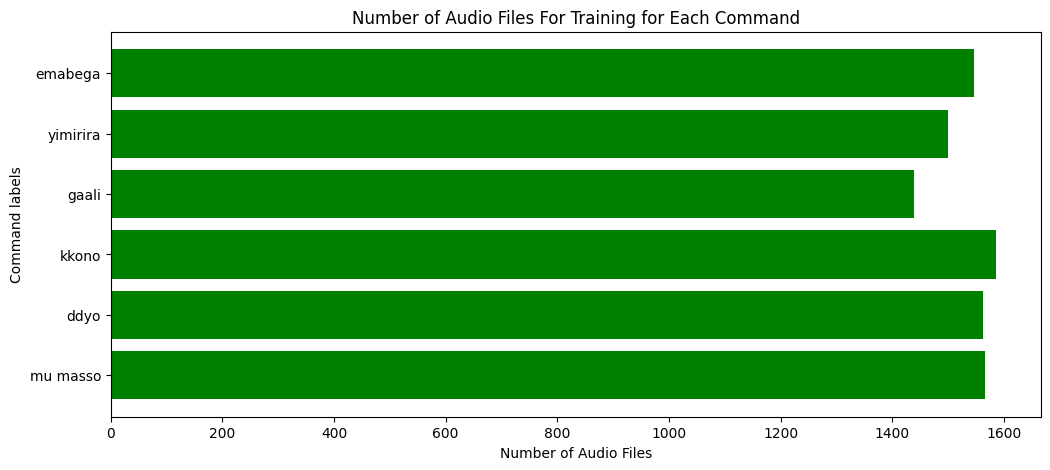

In [8]:
plt.figure(figsize=(12, 5))
plt.barh(list(counts.keys()), list(counts.values()), color='green')
plt.xlabel('Number of Audio Files')
plt.ylabel('Command labels')
plt.title('Number of Audio Files For Training for Each Command')
plt.show()

### 2. Test dataset

In [9]:
counts = count_audio_files_in_subfolders(test_data_dir)
print(f'Test \n{counts}')
print()

Test 
{'mu masso': 306, 'ddyo': 302, 'kkono': 309, 'gaali': 307, 'yimirira': 306, 'emabega': 301}



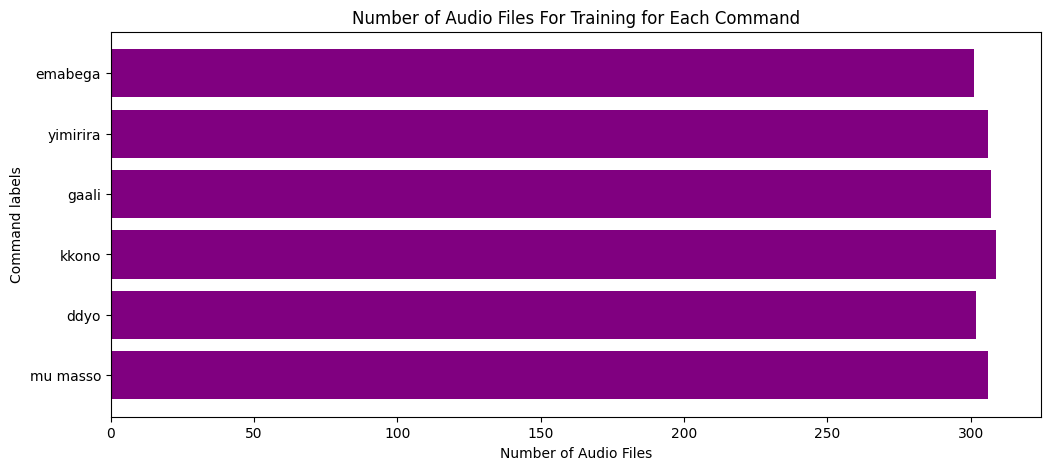

In [10]:
plt.figure(figsize=(12, 5))
plt.barh(list(counts.keys()), list(counts.values()), color='purple')
plt.xlabel('Number of Audio Files')
plt.ylabel('Command labels')
plt.title('Number of Audio Files For Training for Each Command')
plt.show()

## Audio Properties and Parameters

### Load six audio files each from the six subfolders

In [11]:
ddyo_file_path = os.path.join(TRAIN_DATASET_PATH, 'ddyo', 'ddyo #107.wav')
kkono_file_path = os.path.join(TRAIN_DATASET_PATH, 'kkono', 'kkono #67.wav')
emabega_file_path = os.path.join(TRAIN_DATASET_PATH, 'emabega', 'emabega #225.wav')
mumasso_file_path = os.path.join(TRAIN_DATASET_PATH, 'mu masso', 'mu masso #140.wav')
yimirira_file_path = os.path.join(TRAIN_DATASET_PATH, 'yimirira', 'yimirira-3 #58-05.wav')
gaali_file_path = os.path.join(TRAIN_DATASET_PATH, 'gaali', 'gaali #371.wav')

In [12]:
file_paths = [
    ddyo_file_path, 
    kkono_file_path, 
    emabega_file_path,
    mumasso_file_path, 
    yimirira_file_path, 
    gaali_file_path
]

### Audio Properties

In [13]:
for file_path in file_paths:
    audio_signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
    audio = wave.open(file_path, 'rb')

    num_channels = audio.getnchannels()
    frame_rate = audio.getframerate()
    num_frames = audio.getnframes()
    duration = num_frames / float(frame_rate)

    print(f"\nAudio Properties for {os.path.basename(file_path)}")
    print(f"Number of channels:   {num_channels}")
    print(f"Frame rate (Hz):      {frame_rate}")
    print(f"Duration (s):         {duration}")

    audio.close()

print()


Audio Properties for ddyo #107.wav
Number of channels:   1
Frame rate (Hz):      16000
Duration (s):         1.34

Audio Properties for kkono #67.wav
Number of channels:   1
Frame rate (Hz):      16000
Duration (s):         1.6

Audio Properties for emabega #225.wav
Number of channels:   1
Frame rate (Hz):      16000
Duration (s):         1.42

Audio Properties for mu masso #140.wav
Number of channels:   1
Frame rate (Hz):      16000
Duration (s):         1.24

Audio Properties for yimirira-3 #58-05.wav
Number of channels:   1
Frame rate (Hz):      16000
Duration (s):         1.1319375

Audio Properties for gaali #371.wav
Number of channels:   1
Frame rate (Hz):      16000
Duration (s):         1.24



## Play the audio files

In [14]:
for file_path in file_paths:
    print(f"Playing {os.path.basename(file_path)}\n")
    audio = Audio(file_path)
    display(audio)    

Playing ddyo #107.wav



Playing kkono #67.wav



Playing emabega #225.wav



Playing mu masso #140.wav



Playing yimirira-3 #58-05.wav



Playing gaali #371.wav



## Visualize the audio waveform

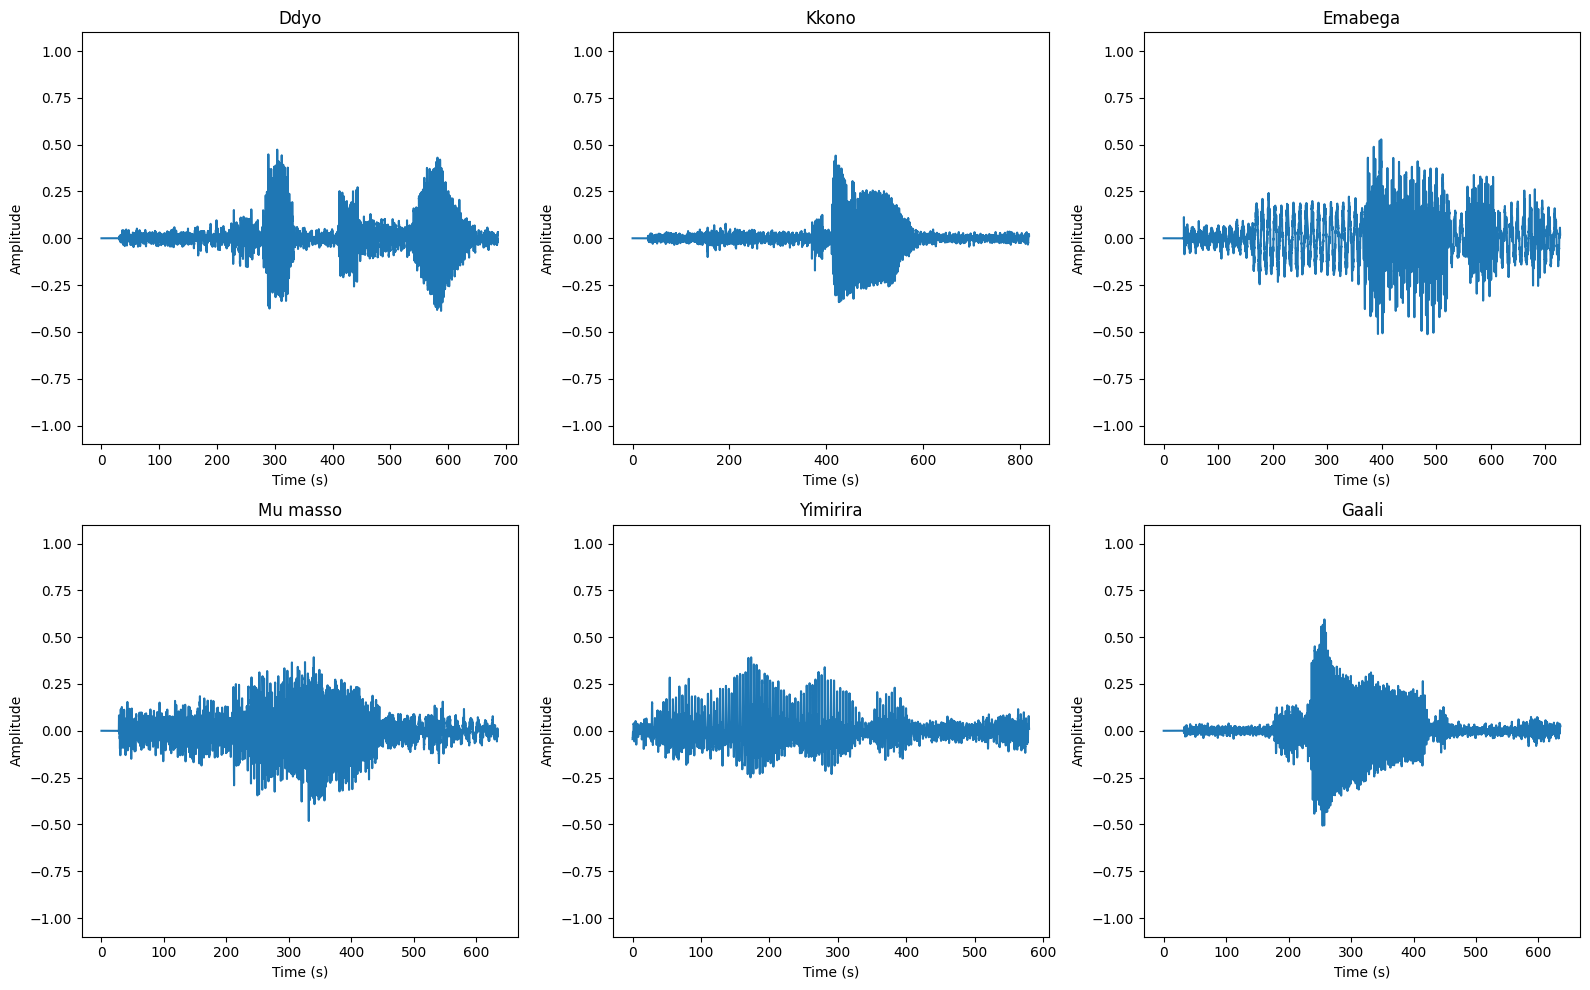

In [15]:
label_names_slice = ['Ddyo', 'Kkono', 'Emabega', 'Mu masso', 'Yimirira', 'Gaali']

plt.figure(figsize=(16, 10))
rows = 2
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_path = file_paths[i] 
    audio_signal, _ = librosa.load(audio_path, sr=SAMPLE_RATE)
    time = librosa.times_like(audio_signal, sr=SAMPLE_RATE)
    plt.plot(time, audio_signal)
    plt.title(label_names_slice[i])
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.ylim([-1.1, 1.1])
plt.tight_layout()
plt.show()


## Spectrogram

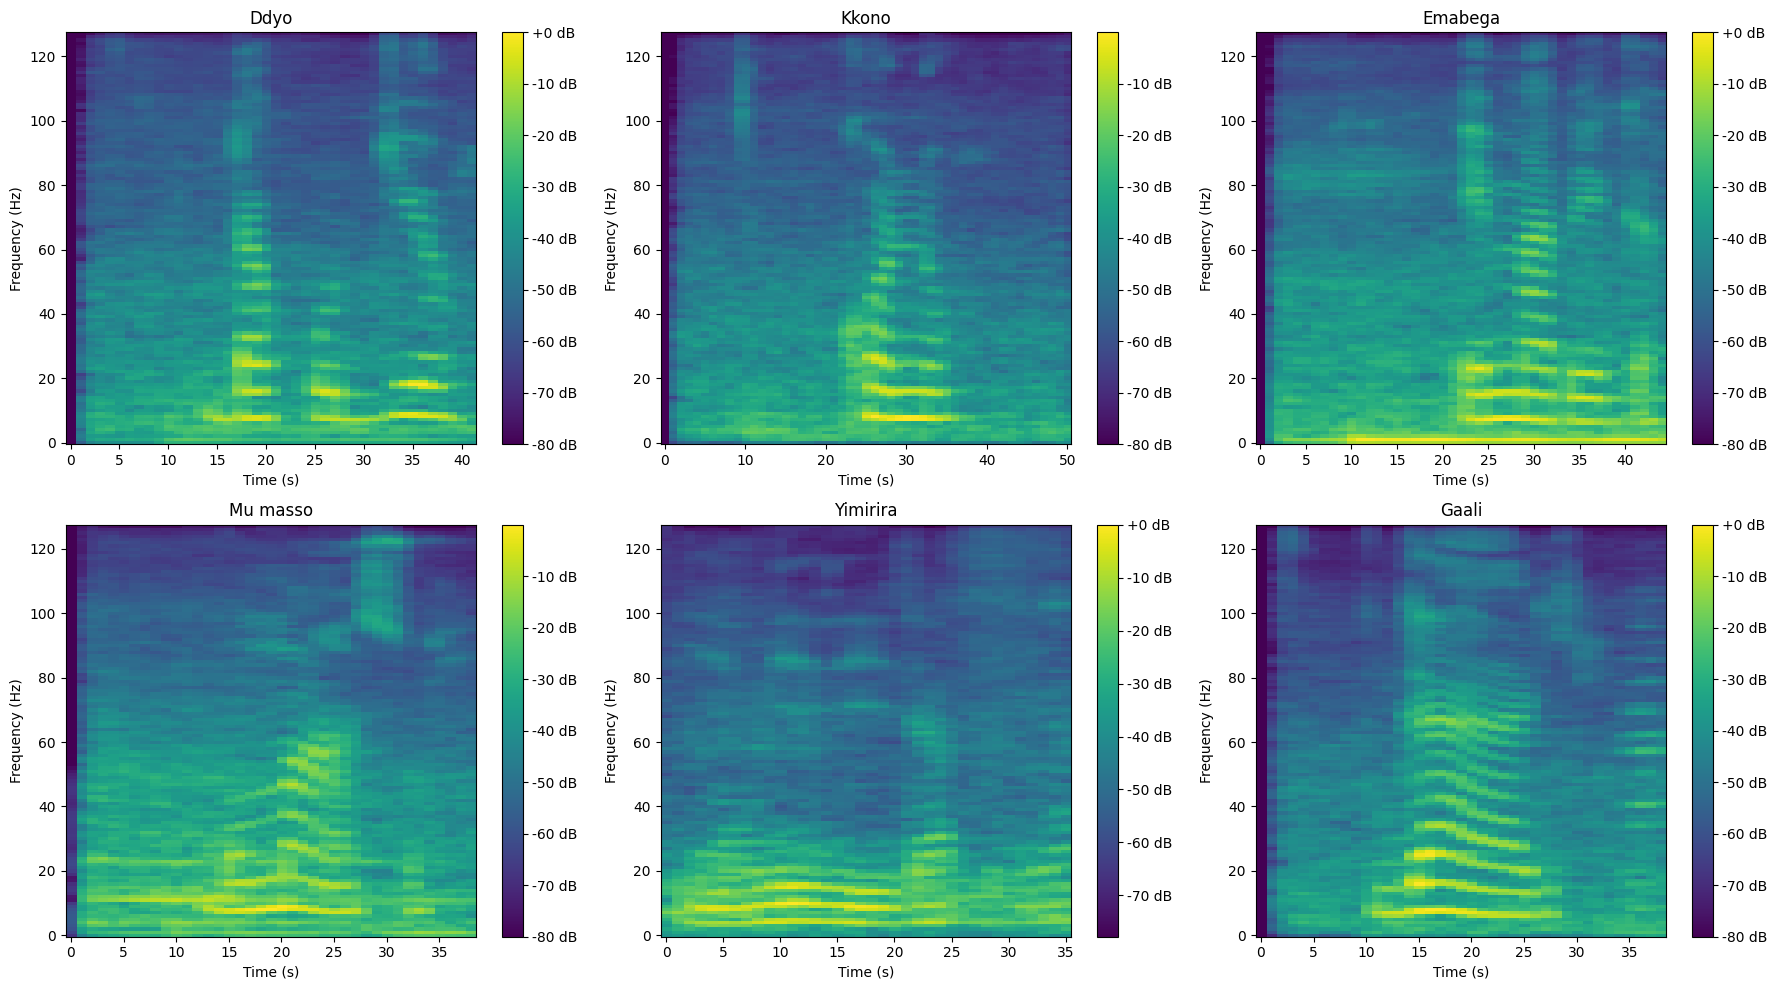

In [16]:
plt.figure(figsize=(18, 10))

# Plot spectrograms
for i, audio_file in enumerate(file_paths, start=1):
    plt.subplot(2, 3, i)
    audio_signal, sample_rate = librosa.load(audio_file, sr=None)
    spectrogram = librosa.feature.melspectrogram(y=audio_signal, sr=sample_rate)
    plt.imshow(librosa.power_to_db(spectrogram, ref=np.max), aspect='auto', origin='lower', cmap='viridis')
    plt.title(label_names_slice[i-1])
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()


## MFCCs

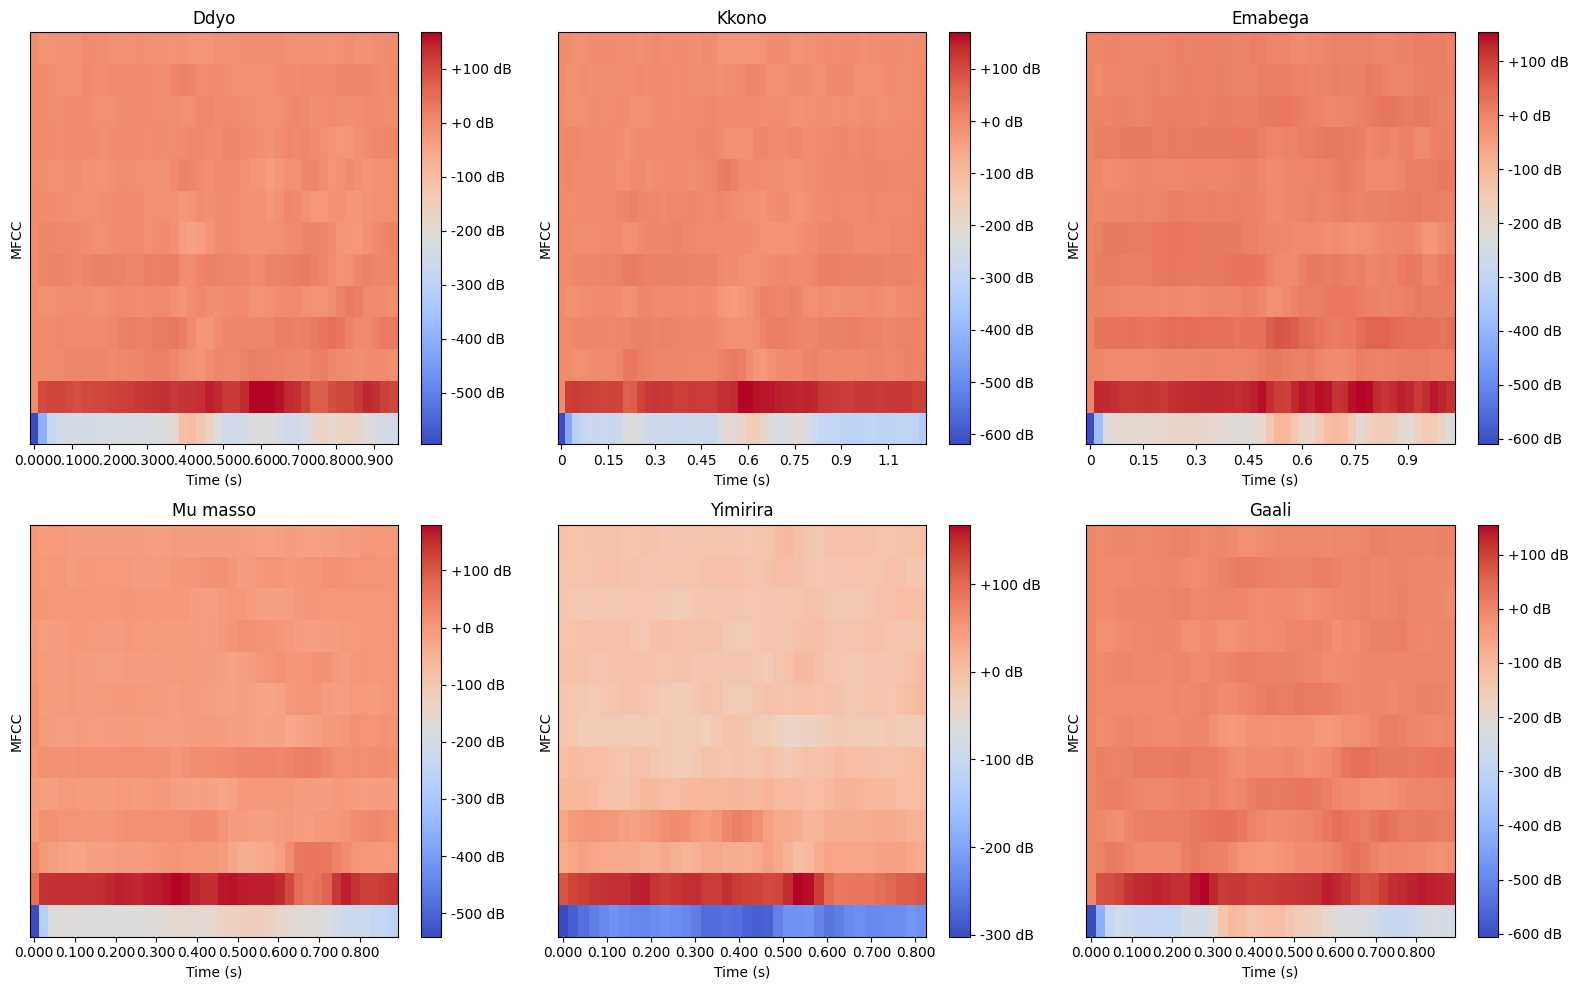

In [17]:

plt.figure(figsize=(16, 10))
rows = 2
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_path = file_paths[i]
    audio_signal, sample_rate = librosa.load(audio_path, sr=SAMPLE_RATE)
    mfccs = librosa.feature.mfcc(y=audio_signal, sr=sample_rate, n_mfcc=13)
    librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title(label_names_slice[i])
    plt.xlabel('Time (s)')
    plt.ylabel('MFCC')
plt.tight_layout()
plt.show()


# Dataset Preparaption

## 1. Train and validation Datasets

In [18]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=train_data_dir,
    batch_size=64,
    validation_split=0.3,
    seed=0,
    output_sequence_length=SAMPLE_RATE,
    subset='both')

label_names = np.array(train_ds.class_names)
print()

Found 9203 files belonging to 6 classes.
Using 6443 files for training.
Using 2760 files for validation.



In [19]:
element_spec = train_ds.element_spec
print(element_spec)
print()

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))



In [20]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [21]:
# Inspecting the shape of the audio and label

for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


## 2. Test dataset

In [22]:
test_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=test_data_dir,
    batch_size=64,
    validation_split=None,  # No need to split the test dataset
    seed=0,
    output_sequence_length=SAMPLE_RATE,
    shuffle=False  # Disable shuffling for the test dataset
)

test_ds = test_ds.map(squeeze, tf.data.AUTOTUNE)


Found 1831 files belonging to 6 classes.


In [23]:
for example_audio, example_labels in test_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)
print()

(64, 16000)
(64,)



# Feature Extraction

In [24]:
def get_spectrogram(waveform):
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

## Tensorized waveform
The shapes of a tensorized waveform and the corresponding spectrogram, and play the original audio.

In [25]:
for i in range(6):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: ddyo
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


AttributeError: 'function' object has no attribute 'display'

### Visualization of spectrogram

In [26]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
      
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

### Plot of waveform and spectrogram.

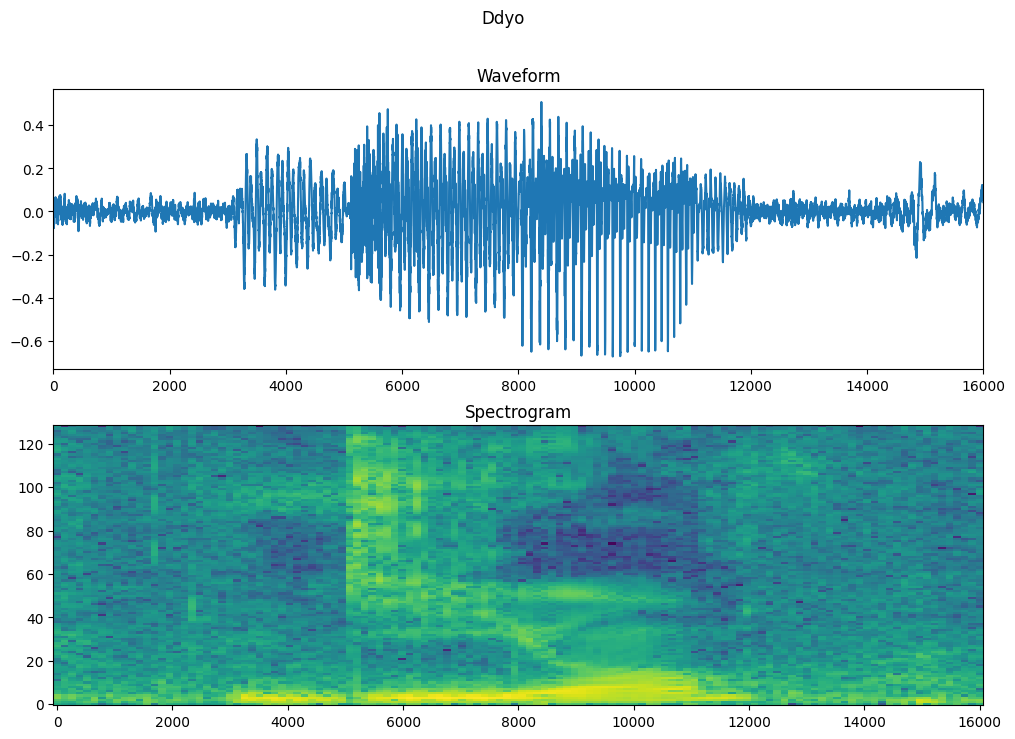

In [27]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

## Create spectrogram datasets

In [28]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [29]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [30]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [31]:
train_spectrogram_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 124, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [32]:
val_spectrogram_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 124, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [33]:
test_spectrogram_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 124, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Visualization of the spectrograms

In [34]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

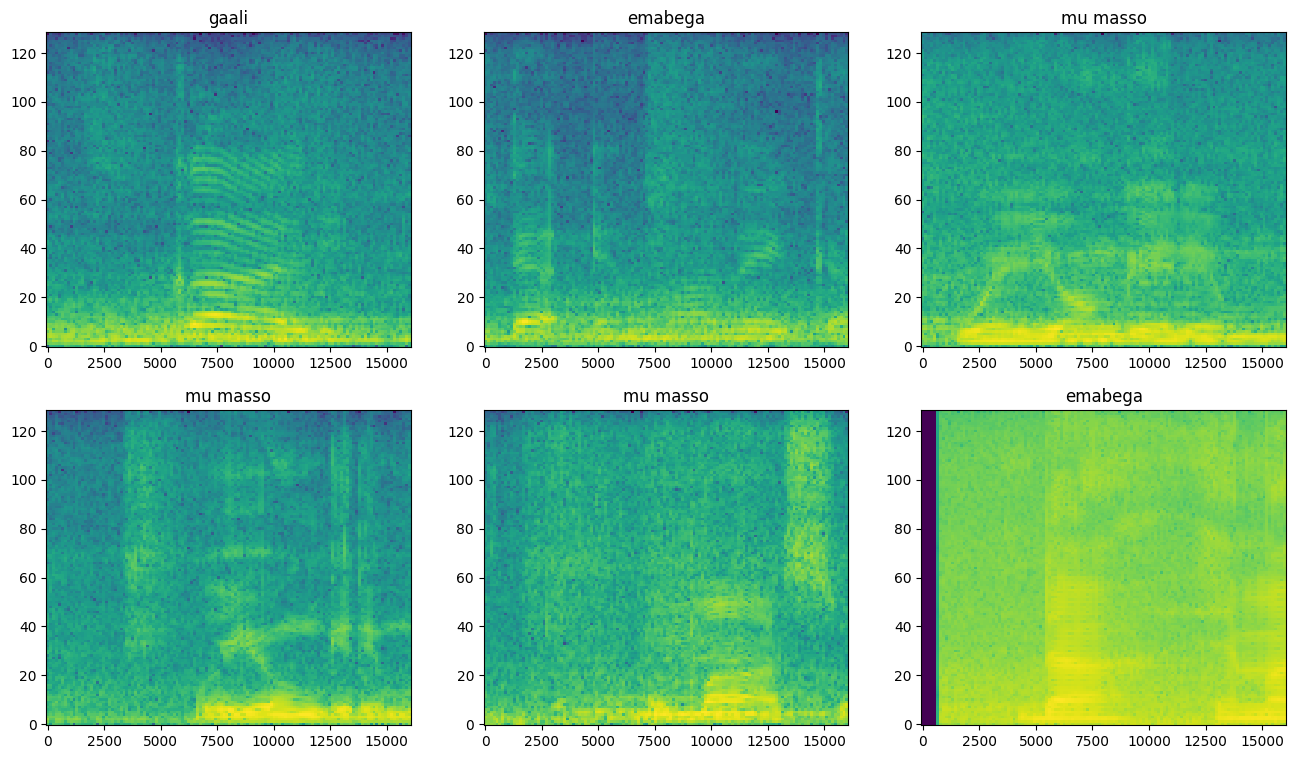

In [35]:
rows = 2
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

# Packages and Libraries

# Building Models

## Model 1

1. **Input Layer:** Defines the input shape for the model based on the shape of the spectrogram images.
2. **Resizing Layer:** Resizes the input spectrogram images to a fixed size of 32x32 pixels.
3. **Normalization Layer:** Normalizes the input data using statistics computed from the training dataset.
4. **Convolutional Layers:** Two Conv2D layers with ReLU activation functions, followed by max pooling.
5. **Dropout Layer:** Applies dropout regularization to prevent overfitting.
6. **Flatten Layer:** Flattens the output of the previous layer into a 1D vector.
7. **Dense Layers:** Two Dense layers with ReLU activation functions, followed by the output layer with logits for each class.

### Input Shape

In [36]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)

Input shape: (124, 129, 1)


### Normalization layer

In [37]:
num_labels = len(label_names)
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

### Model Arch

In [38]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

### Compile the model

In [39]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

### Train the model

In [40]:
EPOCHS = 20
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20
101/101 [==============================] - 23s 210ms/step - loss: 1.1575 - accuracy: 0.5619 - val_loss: 0.8682 - val_accuracy: 0.6989
Epoch 2/20
101/101 [==============================] - 19s 185ms/step - loss: 0.7845 - accuracy: 0.7330 - val_loss: 0.6931 - val_accuracy: 0.7848
Epoch 3/20
101/101 [==============================] - 20s 194ms/step - loss: 0.6270 - accuracy: 0.7821 - val_loss: 0.6060 - val_accuracy: 0.8025
Epoch 4/20
101/101 [==============================] - 19s 189ms/step - loss: 0.5509 - accuracy: 0.8130 - val_loss: 0.5731 - val_accuracy: 0.8264
Epoch 5/20
101/101 [==============================] - 20s 199ms/step - loss: 0.4620 - accuracy: 0.8432 - val_loss: 0.5325 - val_accuracy: 0.8315
Epoch 6/20
101/101 [==============================] - 19s 186ms/step - loss: 0.4129 - accuracy: 0.8591 - val_loss: 0.4954 - val_accuracy: 0.8446
Epoch 7/20
101/101 [==============================] - 18s 182ms/step - loss: 0.3658 - accuracy: 0.8751 - val_loss: 0.4881 - val_ac

### Plot Accuracy and Loss

Text(0, 0.5, 'Accuracy [%]')

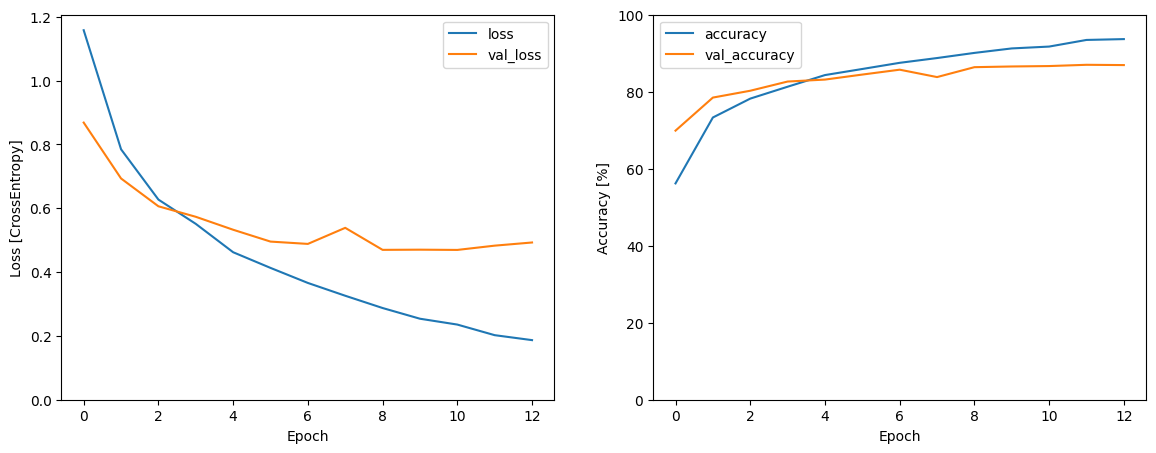

In [41]:
metrics = history.history
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model performance

Run the model on the test set and check the model's performance:

In [42]:
model.evaluate(test_spectrogram_ds, return_dict=True)

29/29 [==============================] - 2s 63ms/step - loss: 0.5540 - accuracy: 0.8427


{'loss': 0.5540124177932739, 'accuracy': 0.8427088856697083}

In [43]:
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

29/29 [==============================] - 1s 35ms/step


In [44]:
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Precision: {precision}")
print(f"Recall:    {recall}")
print(f"F1-score:  {f1}")

Precision: 0.8491473900743981
Recall:    0.8427089022392136
F1-score:  0.8434789082631617


### Display a confusion matrix

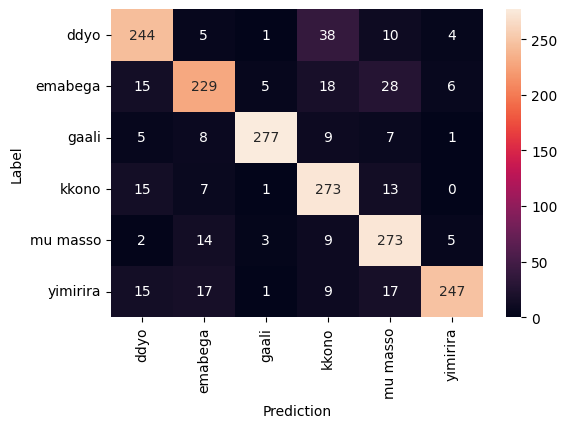

In [45]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Save the TensorFlow Model

In [49]:
# KERAS_MODEL_NAME = "model_1.keras"
# model.save(KERAS_MODEL_NAME)

In [48]:
# convert_bytes(get_file_size(KERAS_MODEL_NAME), "KB")

## Model 2


1. **Input Layer**: Defines the input shape for the model based on the shape of the spectrogram images.
2. **Resizing Layer**: Resizes the input spectrogram images to a fixed size of 32x32 pixels.
3. **Normalization Layer**: Normalizes the input data using statistics computed from the training dataset.
4. **Convolutional Layers**:
   - 4.1. First Conv2D Layer: Applies 32 filters with a 3x3 kernel size and ReLU activation function.
   - 4.2. Batch Normalization Layer: Normalizes the activations of the previous convolutional layer.
   - 4.3. MaxPooling2D Layer: Performs max pooling to downsample the feature maps.
5. **Convolutional Layers**:
   - 5.1. Second Conv2D Layer: Applies 64 filters with a 3x3 kernel size and ReLU activation function.
   - 5.2. Batch Normalization Layer: Normalizes the activations of the previous convolutional layer.
   - 5.3. MaxPooling2D Layer: Performs max pooling to downsample the feature maps.
6. **Dropout Layer**: Applies dropout regularization with a dropout rate of 0.25 to prevent overfitting.
7. **Flatten Layer**: Flattens the output of the previous layer into a 1D vector.
8. **Dense Layers**:
   - 8.1. First Dense Layer: Applies 128 neurons with ReLU activation function.
   - 8.2. Dropout Layer: Applies dropout regularization with a dropout rate of 0.5.
   - 8.3. Second Dense Layer: Outputs logits for each class, with the number of units equal to the number of labels.

### Input Shape

In [50]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)

Input shape: (124, 129, 1)


### Normalization layer

In [51]:
num_labels = len(label_names)
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

### Model Arch

In [52]:
model_2 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model_2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_1 (Normaliza  (None, 32, 32, 1)         3         
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 30, 30, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                      

### Compile the  Model

In [53]:
model_2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

timizer=tf.keras.optimizers.Adam(),
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),


### Train the Model

In [54]:
EPOCHS = 20
history = model_2.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20
101/101 [==============================] - 11s 86ms/step - loss: 1.5074 - accuracy: 0.4695 - val_loss: 1.7090 - val_accuracy: 0.2855
Epoch 2/20
101/101 [==============================] - 8s 82ms/step - loss: 1.0043 - accuracy: 0.6359 - val_loss: 2.2132 - val_accuracy: 0.2721
Epoch 3/20
101/101 [==============================] - 8s 76ms/step - loss: 0.8008 - accuracy: 0.7107 - val_loss: 2.0463 - val_accuracy: 0.4083
Epoch 3: early stopping


### Plot Accuracy and Loss

Text(0, 0.5, 'Accuracy [%]')

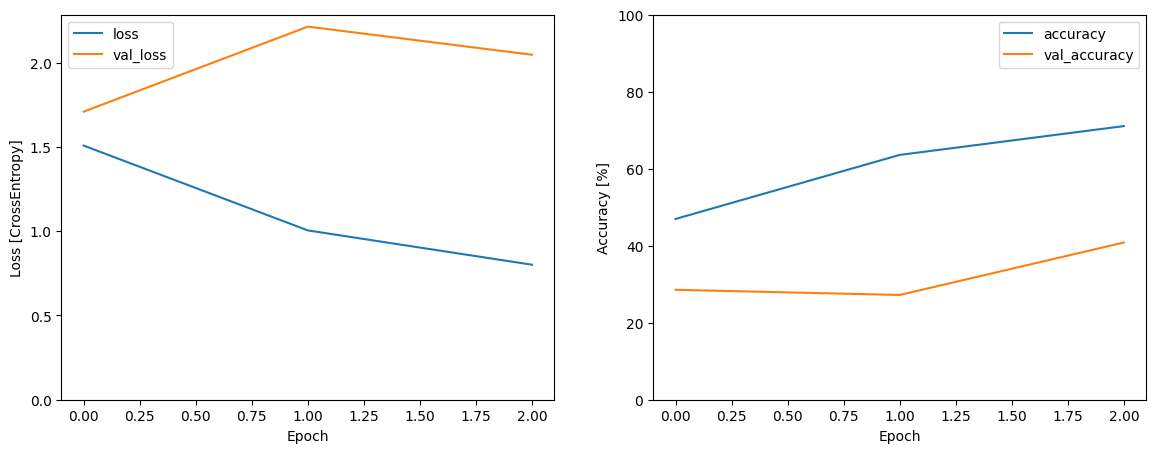

In [55]:
metrics = history.history
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model performance

In [56]:
model_2.evaluate(test_spectrogram_ds, return_dict=True)

29/29 [==============================] - 1s 21ms/step - loss: 2.2090 - accuracy: 0.3687


{'loss': 2.2089571952819824, 'accuracy': 0.36865100264549255}

In [57]:
y_pred = model_2.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

29/29 [==============================] - 1s 19ms/step


In [58]:
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Precision: {precision}")
print(f"Recall:    {recall}")
print(f"F1-score:  {f1}")

Precision: 0.526793037177755
Recall:    0.3686510103768433
F1-score:  0.29486212252431687


### Display the confusion matix

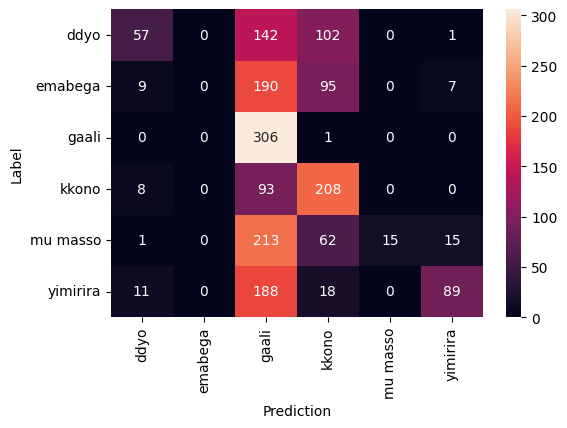

In [59]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Save the TensorFlow model

In [60]:
KERAS_MODEL_NAME = "model_2.keras"
model_2.save(KERAS_MODEL_NAME)

In [61]:
convert_bytes(get_file_size(KERAS_MODEL_NAME), "KB")

File size: 3747.175 Kilobytes


## Model 3

1. **Input Layer**: Defines the input shape for the model based on the shape of the spectrogram images.
2. **Convolutional Layers**:
   - 2.1. First Conv2D Layer: Applies 32 filters with a 3x3 kernel size, ReLU activation function, and dilation rate of (2, 2).
   - 2.2. MaxPooling2D Layer: Performs max pooling to downsample the feature maps.
3. **Convolutional Layers**:
   - 3.1. Second Conv2D Layer: Applies 64 filters with a 3x3 kernel size, ReLU activation function, and dilation rate of (2, 2).
   - 3.2. MaxPooling2D Layer: Performs max pooling to downsample the feature maps.
4. **Convolutional Layers**:
   - 4.1. Third Conv2D Layer: Applies 128 filters with a 3x3 kernel size, ReLU activation function, and dilation rate of (2, 2).
   - 4.2. GlobalAveragePooling2D Layer: Performs global average pooling to reduce spatial dimensions.
5. **Dense Layers**:
   - 5.1. Dense Layer: Applies 128 neurons with ReLU activation function.
   - 5.2. Dropout Layer: Applies dropout regularization with a dropout rate of 0.5.
   - 5.3. Dense Layer: Outputs logits for each class, with the number of units equal to the number of labels.

### Input shape 

In [62]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)

Input shape: (124, 129, 1)


### Model Arch

In [63]:
model_3 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, 3, activation='relu', dilation_rate=(2, 2)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu', dilation_rate=(2, 2)),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu', dilation_rate=(2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model_3.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 120, 125, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 60, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 58, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 28, 29, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 25, 128)       73856     
                                                                 
 global_average_pooling2d (  (None, 128)              

### Compile the model

In [64]:
model_3.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

### Train the model

In [65]:
EPOCHS = 20
history = model_3.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20


2024-03-10 07:52:28.341953: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 123863040 exceeds 10% of free system memory.
2024-03-10 07:52:28.387443: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 122880000 exceeds 10% of free system memory.
2024-03-10 07:52:28.606103: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 53215232 exceeds 10% of free system memory.
2024-03-10 07:52:28.667044: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 53215232 exceeds 10% of free system memory.
2024-03-10 07:52:28.891040: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 53215232 exceeds 10% of free system memory.


101/101 [==============================] - 123s 1s/step - loss: 1.5582 - accuracy: 0.3604 - val_loss: 1.2403 - val_accuracy: 0.5580
Epoch 2/20
101/101 [==============================] - 213s 2s/step - loss: 1.1418 - accuracy: 0.5657 - val_loss: 0.9904 - val_accuracy: 0.6554
Epoch 3/20
101/101 [==============================] - 150s 1s/step - loss: 0.9538 - accuracy: 0.6537 - val_loss: 0.8577 - val_accuracy: 0.7214
Epoch 4/20
101/101 [==============================] - 152s 2s/step - loss: 0.8537 - accuracy: 0.6958 - val_loss: 0.7686 - val_accuracy: 0.7467
Epoch 5/20
101/101 [==============================] - 162s 2s/step - loss: 0.7661 - accuracy: 0.7312 - val_loss: 0.7028 - val_accuracy: 0.7786
Epoch 6/20
101/101 [==============================] - 132s 1s/step - loss: 0.7085 - accuracy: 0.7531 - val_loss: 0.6562 - val_accuracy: 0.7902
Epoch 7/20
101/101 [==============================] - 150s 1s/step - loss: 0.6676 - accuracy: 0.7729 - val_loss: 0.5949 - val_accuracy: 0.8116
Epoch 8/20

### Plot Accuracy and Loss

Text(0, 0.5, 'Accuracy [%]')

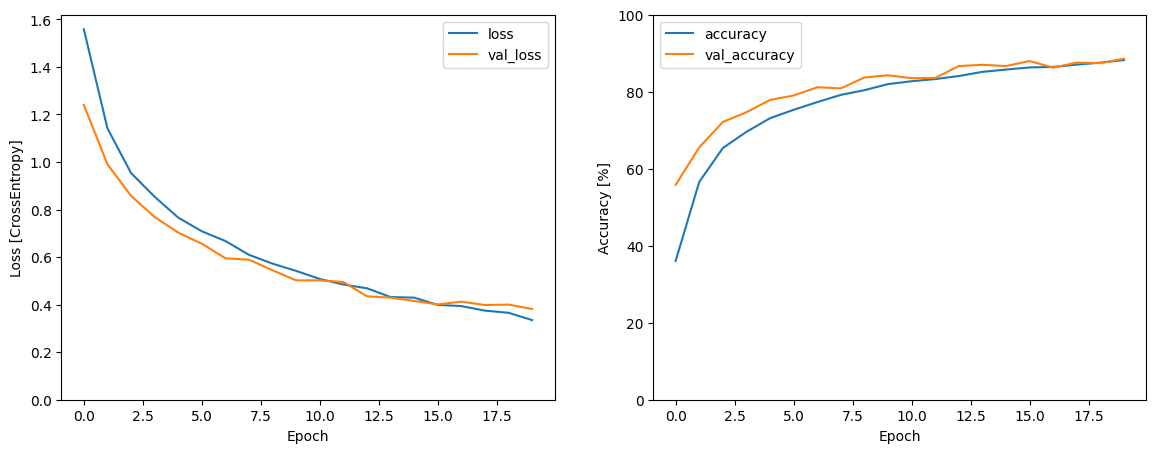

In [66]:
metrics = history.history
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model performance

Run the model on the test set and check the model's performance:

In [67]:
model_3.evaluate(test_spectrogram_ds, return_dict=True)

29/29 [==============================] - 12s 404ms/step - loss: 0.3677 - accuracy: 0.8853


{'loss': 0.3676931858062744, 'accuracy': 0.885308563709259}

### Display a confusion matrix

In [68]:
y_pred = model_3.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

29/29 [==============================] - 13s 429ms/step


In [69]:
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Precision: {precision}")
print(f"Recall:    {recall}")
print(f"F1-score:  {f1}")

Precision: 0.8881911790623355
Recall:    0.8853085745494266
F1-score:  0.8858263463320375


## Display the confusion matix

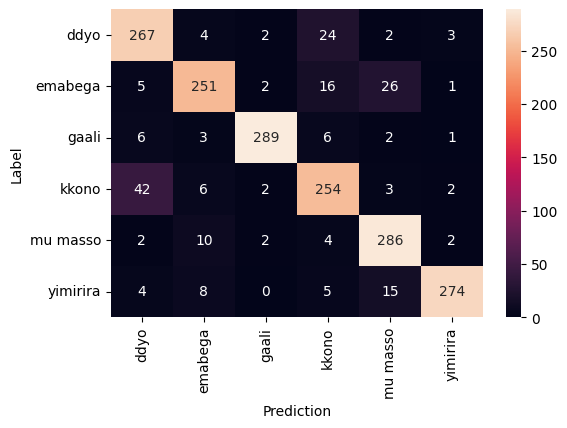

In [70]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Tensorflow model

In [71]:
KERAS_MODEL_NAME = "model_3.keras"
model_3.save(KERAS_MODEL_NAME)

In [72]:
convert_bytes(get_file_size(KERAS_MODEL_NAME), "MB")

File size: 1.301 Megabytes


## Model 4

1. Input layer: Accepts input data of shape `input_shape`.
2. Conv2D layer with 32 filters, kernel size 3x3, and ReLU activation. Dilated convolution with dilation rate (2, 2).
3. MaxPooling2D layer.
4. Conv2D layer with 64 filters, kernel size 3x3, and ReLU activation. Dilated convolution with dilation rate (2, 2).
5. GlobalAveragePooling2D layer: Reduces spatial dimensions to 1x1.
6. Dense layer with 64 neurons and ReLU activation.
7. Dropout layer with dropout rate of 0.5.
8. Dense output layer with `num_labels` neurons (output classes).


### Input shape 

In [73]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

Input shape: (124, 129, 1)


### Model Arch

In [74]:
model_4 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, 3, activation='relu', dilation_rate=(2, 2)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu', dilation_rate=(2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 120, 125, 32)      320       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 60, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 56, 58, 64)        18496     
                                                                 
 global_average_pooling2d_1  (None, 64)                0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dropout_5 (Dropout)         (None, 64)               

### Compile the model

In [75]:
model_4.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

### Train the model

In [76]:
EPOCHS = 30
history = model_4.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20
101/101 [==============================] - 113s 1s/step - loss: 1.7367 - accuracy: 0.2423 - val_loss: 1.6139 - val_accuracy: 0.3138
Epoch 2/20
101/101 [==============================] - 116s 1s/step - loss: 1.4989 - accuracy: 0.3975 - val_loss: 1.3656 - val_accuracy: 0.4670
Epoch 3/20
101/101 [==============================] - 112s 1s/step - loss: 1.3377 - accuracy: 0.4662 - val_loss: 1.2489 - val_accuracy: 0.5228
Epoch 4/20
101/101 [==============================] - 112s 1s/step - loss: 1.2435 - accuracy: 0.5117 - val_loss: 1.1868 - val_accuracy: 0.5464
Epoch 5/20
101/101 [==============================] - 115s 1s/step - loss: 1.1983 - accuracy: 0.5262 - val_loss: 1.1527 - val_accuracy: 0.5649
Epoch 6/20
101/101 [==============================] - 107s 1s/step - loss: 1.1552 - accuracy: 0.5560 - val_loss: 1.1275 - val_accuracy: 0.5793
Epoch 7/20
101/101 [==============================] - 116s 1s/step - loss: 1.1308 - accuracy: 0.5657 - val_loss: 1.0955 - val_accuracy: 0.6062

### Plot Accuracy and Loss

Text(0, 0.5, 'Accuracy [%]')

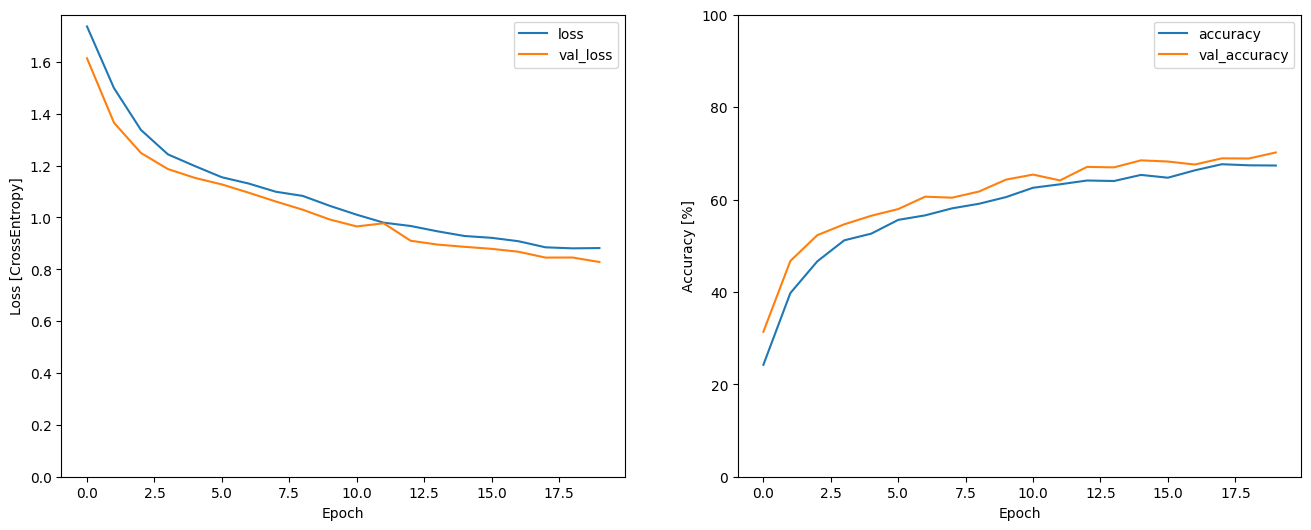

In [77]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model

In [78]:
model_4.evaluate(test_spectrogram_ds, return_dict=True)

29/29 [==============================] - 7s 235ms/step - loss: 0.9730 - accuracy: 0.6428


{'loss': 0.9729909300804138, 'accuracy': 0.6428181529045105}

In [79]:
y_pred = model_4.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

29/29 [==============================] - 7s 240ms/step


In [80]:
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Precision: {precision}")
print(f"Recall:    {recall}")
print(f"F1-score:  {f1}")

Precision: 0.6524723858927548
Recall:    0.642818132168214
F1-score:  0.645273438155763


### Display a confusion matrix

In [81]:
y_pred = model_4.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

29/29 [==============================] - 7s 246ms/step


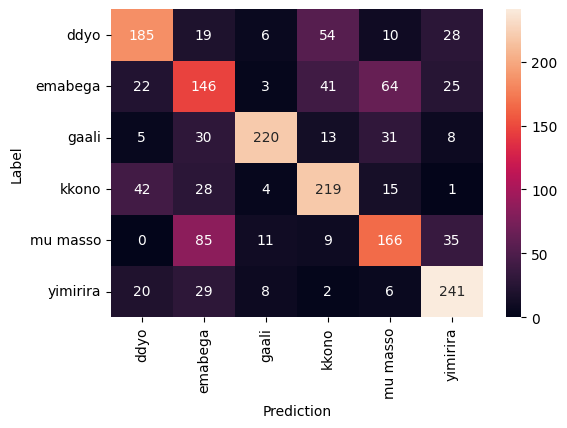

In [82]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Model new

In [85]:
# Assuming train_mel_spec_ds is your training dataset of Mel spectrograms
example_spectrograms = next(iter(test_spectrogram_ds))[0]

input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names_slice)

norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()


Input shape: (124, 129, 1)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_3 (Normaliza  (None, 32, 32, 1)         3         
 tion)                                                           
                                                                 
 conv2d_9 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)       

In [86]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
history = model.fit(train_spectrogram_ds, 
                    validation_data=val_spectrogram_ds, 
                    epochs=30)

# Evaluate the model
loss, accuracy = model.evaluate(test_spectrogram_ds)
print('Test loss:', loss)
print('Test accuracy:', accuracy)


Epoch 1/30
101/101 [==============================] - 9s 87ms/step - loss: 1.2052 - accuracy: 0.5378 - val_loss: 0.8854 - val_accuracy: 0.7018
Epoch 2/30
101/101 [==============================] - 9s 85ms/step - loss: 0.8383 - accuracy: 0.6997 - val_loss: 0.7222 - val_accuracy: 0.7591
Epoch 3/30
101/101 [==============================] - 9s 86ms/step - loss: 0.6782 - accuracy: 0.7599 - val_loss: 0.6462 - val_accuracy: 0.7975
Epoch 4/30
101/101 [==============================] - 8s 84ms/step - loss: 0.5947 - accuracy: 0.7933 - val_loss: 0.5859 - val_accuracy: 0.8199
Epoch 5/30
101/101 [==============================] - 9s 85ms/step - loss: 0.5097 - accuracy: 0.8217 - val_loss: 0.5695 - val_accuracy: 0.8130
Epoch 6/30
101/101 [==============================] - 10s 95ms/step - loss: 0.4491 - accuracy: 0.8476 - val_loss: 0.5205 - val_accuracy: 0.8377
Epoch 7/30
101/101 [==============================] - 9s 91ms/step - loss: 0.4062 - accuracy: 0.8605 - val_loss: 0.5156 - val_accuracy: 0.834

Text(0, 0.5, 'Accuracy [%]')

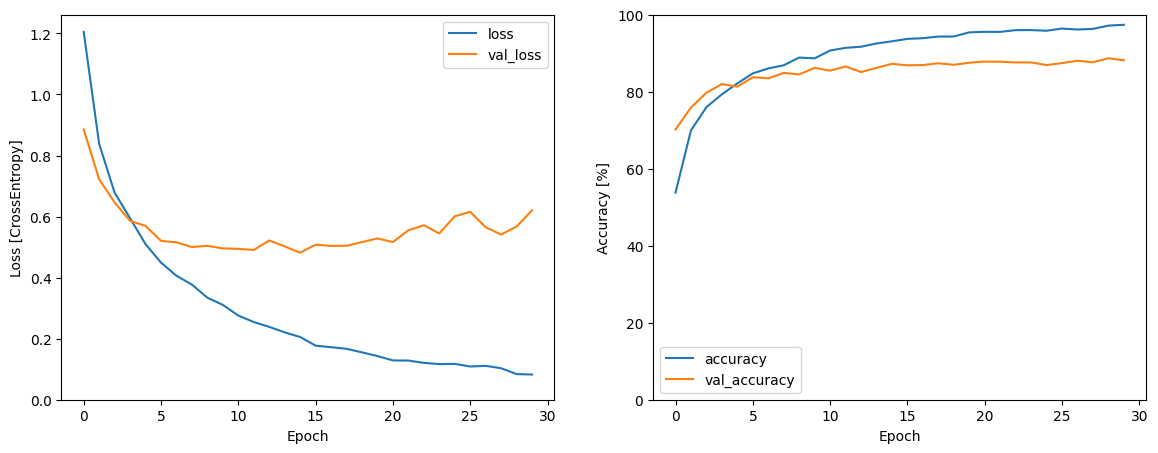

In [87]:
metrics = history.history
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

29/29 [==============================] - 1s 16ms/step
Precision: 0.8543103437725866
Recall:    0.8509011469142546
F1-score:  0.8510139400052744


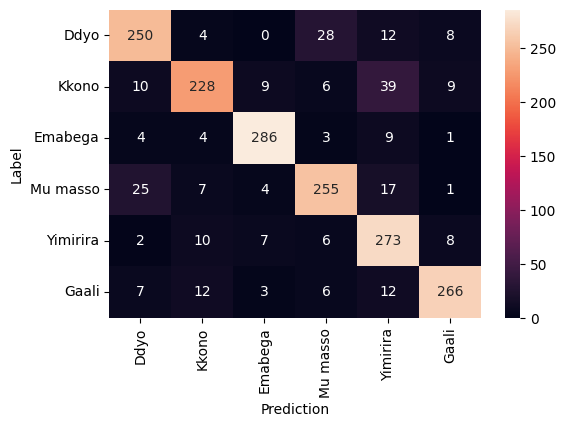

In [88]:
model.evaluate(test_spectrogram_ds, return_dict=True)

y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda spec, lab: lab)), axis=0)

precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Precision: {precision}")
print(f"Recall:    {recall}")
print(f"F1-score:  {f1}")

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names_slice,
            yticklabels=label_names_slice,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()


## Model 1

1. **Input Layer**: Defines the input shape for the model based on the shape of the spectrogram images.
2. **Convolutional Layers**:
   - 2.1. First Conv2D Layer: Applies 32 filters with a 3x3 kernel size, ReLU activation function, and dilation rate of (2, 2).
   - 2.2. MaxPooling2D Layer: Performs max pooling to downsample the feature maps.
3. **Convolutional Layers**:
   - 3.1. Second Conv2D Layer: Applies 64 filters with a 3x3 kernel size, ReLU activation function, and dilation rate of (2, 2).
   - 3.2. MaxPooling2D Layer: Performs max pooling to downsample the feature maps.
4. **Convolutional Layers**:
   - 4.1. Third Conv2D Layer: Applies 128 filters with a 3x3 kernel size, ReLU activation function, and dilation rate of (2, 2).
   - 4.2. GlobalAveragePooling2D Layer: Performs global average pooling to reduce spatial dimensions.
5. **Dense Layers**:
   - 5.1. Dense Layer: Applies 128 neurons with ReLU activation function.
   - 5.2. Dropout Layer: Applies dropout regularization with a dropout rate of 0.5.
   - 5.3. Dense Layer: Outputs logits for each class, with the number of units equal to the number of labels.

### Input shape 

In [89]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names_slice)


Input shape: (124, 129, 1)


### Model Arch

In [90]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, 3, activation='relu', dilation_rate=(2, 2)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu', dilation_rate=(2, 2)),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu', dilation_rate=(2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 120, 125, 32)      320       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 60, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 56, 58, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 28, 29, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 25, 128)       73856     
                                                                 
 global_average_pooling2d_2  (None, 128)              

### Compile the model

In [91]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


### Train the model

In [92]:
EPOCHS = 30
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/30
101/101 [==============================] - 84s 828ms/step - loss: 1.5522 - accuracy: 0.3486 - val_loss: 1.2024 - val_accuracy: 0.5699
Epoch 2/30
101/101 [==============================] - 91s 903ms/step - loss: 1.1092 - accuracy: 0.5850 - val_loss: 1.0249 - val_accuracy: 0.6319
Epoch 3/30
101/101 [==============================] - 87s 862ms/step - loss: 0.9325 - accuracy: 0.6606 - val_loss: 0.8267 - val_accuracy: 0.7420
Epoch 4/30
101/101 [==============================] - 85s 840ms/step - loss: 0.8282 - accuracy: 0.7101 - val_loss: 0.7325 - val_accuracy: 0.7739
Epoch 5/30
101/101 [==============================] - 86s 854ms/step - loss: 0.7489 - accuracy: 0.7408 - val_loss: 0.6763 - val_accuracy: 0.7797
Epoch 6/30
101/101 [==============================] - 90s 891ms/step - loss: 0.6675 - accuracy: 0.7751 - val_loss: 0.6556 - val_accuracy: 0.7949
Epoch 7/30
101/101 [==============================] - 90s 888ms/step - loss: 0.6230 - accuracy: 0.7886 - val_loss: 0.5622 - val_ac

### Plot Accuracy and Loss

Text(0, 0.5, 'Accuracy [%]')

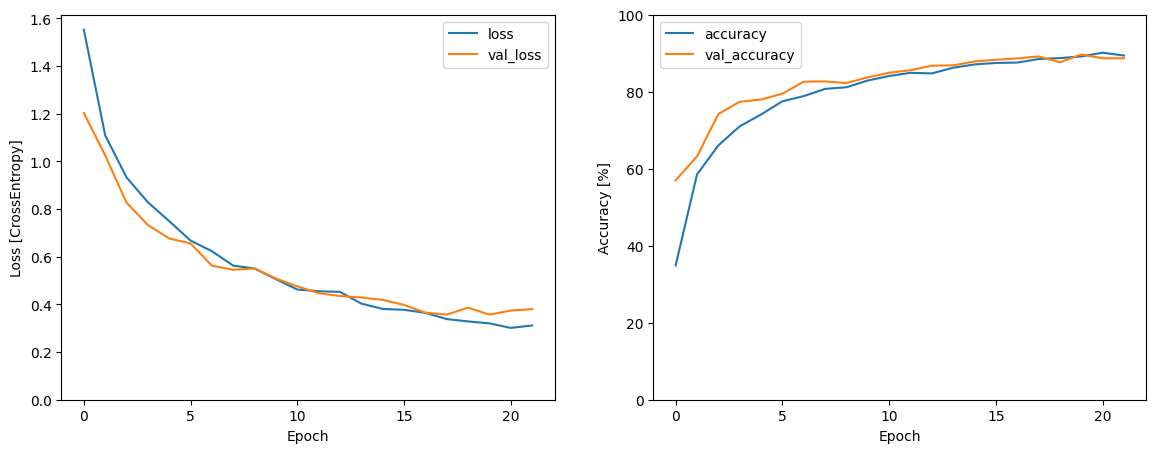

In [93]:
metrics = history.history
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model performance

Run the model on the test set and check the model's performance:

In [94]:
model.evaluate(test_spectrogram_ds, return_dict=True)

29/29 [==============================] - 8s 268ms/step - loss: 0.3738 - accuracy: 0.8777


{'loss': 0.37384557723999023, 'accuracy': 0.8776624798774719}

In [95]:
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

29/29 [==============================] - 8s 271ms/step


In [96]:
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.88888479579786
Recall: 0.8776624795193884
F1-score: 0.8768767523366854


### Display the confusion matix

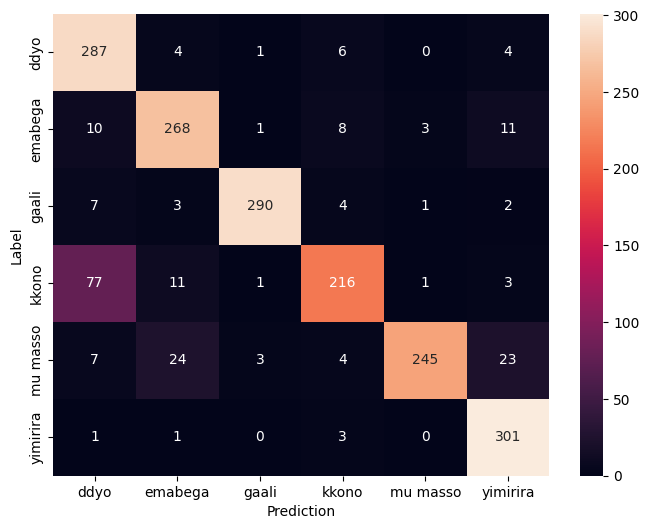

In [97]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Model 4

1. Input layer: Accepts input data of shape `input_shape`.
2. Conv2D layer with 32 filters, kernel size 3x3, and ReLU activation. Dilated convolution with dilation rate (2, 2).
3. MaxPooling2D layer.
4. Conv2D layer with 64 filters, kernel size 3x3, and ReLU activation. Dilated convolution with dilation rate (2, 2).
5. GlobalAveragePooling2D layer: Reduces spatial dimensions to 1x1.
6. Dense layer with 64 neurons and ReLU activation.
7. Dropout layer with dropout rate of 0.5.
8. Dense output layer with `num_labels` neurons (output classes).


### Input shape 

In [ ]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

### Model Arch

In [ ]:
model_4 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, 3, activation='relu', dilation_rate=(2, 2)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu', dilation_rate=(2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model_4.summary()

### Compile the model

In [ ]:
model_4.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

### Train the model

In [ ]:
EPOCHS = 40
history = model_4.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

### Plot Accuracy and Loss

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model

In [ ]:
model_4.evaluate(test_spectrogram_ds, return_dict=True)

In [ ]:
y_pred = model_4.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

In [ ]:
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Precision: {precision}")
print(f"Recall:    {recall}")
print(f"F1-score:  {f1}")

### Display a confusion matrix

In [ ]:
y_pred = model_4.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Model 5

1. **Input Layer**: Defines the input shape for the model based on the shape of the spectrogram images.
2. **Convolutional Layers**:
   - 2.1. First Conv2D Layer: Applies 32 filters with a 3x3 kernel size, ReLU activation function, and dilation rate of (2, 2).
   - 2.2. MaxPooling2D Layer: Performs max pooling to downsample the feature maps.
3. **Convolutional Layers**:
   - 3.1. Second Conv2D Layer: Applies 64 filters with a 3x3 kernel size, ReLU activation function, and dilation rate of (2, 2).
   - 3.2. MaxPooling2D Layer: Performs max pooling to downsample the feature maps.
4. **Convolutional Layers**:
   - 4.1. Third Conv2D Layer: Applies 128 filters with a 3x3 kernel size, ReLU activation function, and dilation rate of (2, 2).
   - 4.2. GlobalAveragePooling2D Layer: Performs global average pooling to reduce spatial dimensions.
5. **Dense Layers**:
   - 5.1. Dense Layer: Applies 128 neurons with ReLU activation function.
   - 5.2. Dropout Layer: Applies dropout regularization with a dropout rate of 0.5.
   - 5.3. Dense Layer: Outputs logits for each class, with the number of units equal to the number of labels.

### Input shape 

In [ ]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names_slice)


### Model Arch

In [ ]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, 3, activation='relu', dilation_rate=(2, 2)),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),  # Add normalization layer here
    layers.Conv2D(64, 3, activation='relu', dilation_rate=(2, 2)),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),  # Add normalization layer here
    layers.Conv2D(128, 3, activation='relu', dilation_rate=(2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()


### Compile the model

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


### Train the model

In [ ]:
# EPOCHS = 30
# history = model.fit(
#     train_mel_spec_ds,
#     validation_data=val_mel_spec_ds,
#     epochs=EPOCHS,
#     callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
# )

In [ ]:
EPOCHS = 50
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
)


### Plot Accuracy and Loss

In [ ]:
metrics = history.history
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model performance

Run the model on the test set and check the model's performance:

In [ ]:
model.evaluate(test_spectrogram_ds, return_dict=True)

In [ ]:
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

In [ ]:
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

### Display the confusion matix

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()